In [30]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.dummy
import sklearn.metrics
import sklearn.ensemble
import torch

In [6]:
# read both the matches and the frames
training_df = pd.read_csv('../data/processed/diff_train.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
test_df = pd.read_csv('../data/processed/diff_test.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
# Reinterpret all values as int32s
training_df = training_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})
test_df = test_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})

test_df

,game_duration,winner,first_kill,first_tower,first_inhibitor,first_baron,first_dragon,first_rift_herald,kill_advantage,gold_advantage,cs_advantage,damage_advantage,tower_advantage,plate_advantage,inhibitor_advantage,dragon_advantage,rift_advantage,baron_advantage
0,1780,1,1,1,1,1,-1,1,3,7354,72,24920,2,8,0,-1,1,0
1,2020,-1,1,1,1,-1,-1,1,-6,316,77,-7851,5,6,1,1,1,-1
2,2430,-1,-1,1,1,-1,-1,-1,2,880,59,-4156,4,1,0,-1,-1,0
3,1952,-1,1,-1,-1,-1,-1,-1,-10,-5034,12,-8164,-3,-1,0,-3,0,0
4,2424,1,1,1,1,1,-1,1,3,7307,143,6028,3,5,0,-1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,1857,1,-1,1,1,1,1,0,5,5743,-10,2542,2,8,0,-2,0,0
3916,1468,1,1,1,1,1,1,1,6,10242,151,21106,5,4,1,1,2,1
3917,2068,-1,1,-1,-1,-1,1,-1,0,-3035,29,-3468,-1,-2,0,3,-2,-1
3918,1868,-1,-1,-1,-1,1,-1,1,-5,-1807,-88,-12656,-3,-5,-2,-3,1,1


In [18]:

def scale_data(X_trn, X_tst):
    # Scale the data with MinMax to avoid negative values
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)

    return X_trn, X_tst
    
## Here we train a dummy classifier to compare performance
def train_dummy_classifier(X, y):
    dummy_clf = sklearn.dummy.DummyClassifier(strategy='uniform', random_state=0)
    # Scale the data with MinMax to avoid negative values
    dummy_clf.fit(X, y)
    return dummy_clf


In [23]:
X_trn = training_df[['kill_advantage','gold_advantage']].values
y_trn = training_df[['winner']].values.T[0]
X_tst = test_df[['kill_advantage','gold_advantage']].values
y_tst = test_df[['winner']].values.T[0]
y_tst.shape

(3920,)

In [33]:
# # Loop created to go through every frame in the data set. 
# # For each frame, pick all corresponding data points, and 
# # train both the neural network and the dummy classifier
# # with it
# current_frame = 25

# # Convert -1 and +1 to 0 and 1 for the tensors to work
# y = np.interp(y, (-1,+1), (0, 1)).astype(np.int32)

# # Two things occur here:
# # 1. Normalize the data from values to a distribution [0,1] in l1 norm
# #    e.g if Red side has 11 kill, and Blue has 9, we represent it as
# #        0.55 and 0.45, respectively.
# # 2. Collapse each blue features to their red features by subtracting them
# #    e.g for ourprevious example, subtracting blue from red would result
# #        to having 0.55-0.45 = 0.1. Hence a 10% advantage for blue
# #        FIXME: could be an arbitrary x[0,:] - 0.5 to avoid doubling up
# def combine(x):
#     x = sklearn.preprocessing.normalize(x.reshape(2,10), norm='l1', axis=0)
#     return x.reshape(20)
# # Normalize the data to have 10 features 
# # corresponding to a better comparison.
# X = np.apply_along_axis(combine, 1, X)
X = 

TRAINING ON FRAME #25
(26565, 20)
(26565, 20)


In [34]:
def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    # Your implementation here. Aim for 1-4 lines.
    scores = [0 for _ in range(len(estimators))]
    for x in range(len(estimators)):
        scores[x] = sklearn.metrics.accuracy_score(y, estimators[x].predict(X))
        print(sklearn.metrics.precision_recall_fscore_support(y, estimators[x].predict(X), average='binary'))
    return scores

In [38]:
def train_kNN_estimators(X_trn,X_tst,y_trn,y_tst):
    estimators = [0 for _ in range(5)]
    param_vals=[1,5,10,15,20]
    for x in range(5):
        estimators[x] = sklearn.neighbors.KNeighborsClassifier(n_neighbors=param_vals[x]).fit(X_trn, y_trn)
    trn_scores = score_estimators(X_trn, y_trn, estimators)
    tst_scores = score_estimators(X_tst, y_tst, estimators)
    X_axis = np.arange(0, 5)
    plt.title(estimators[0].__class__.__name__ + " score vs " + "n_neighbors")
    plt.xlabel("n_neighbors")
    plt.ylabel("score")
    plt.ylim(0.0, 1.05)
    plt.plot(X, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    plt.plot(X, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    plt.legend()
    plt.xticks(X_axis, param_vals)

In [28]:
def train_random_forests(X_trn, X_tst, y_trn, y_tst):
    estimator = np.arange(1, 6) * 50
    depths = np.arange(1, 6) * 5
    estimators_meshed, depths_meshed = np.meshgrid(estimator, depths)

    trn_scores = np.arange(0, 25, dtype=float)
    tst_scores = np.arange(0, 25, dtype=float)
    X_axis = np.arange(0, 25)
    para_vals = np.array(
        ["50:5", "50:10", "50:15", "50:20", "50:25", "100:5", "100:10", "100:15", "100:20", "100:25", "150:5", "150:10",
         "150:15", "150:20","150:25","200:5", "200:10", "200:15", "200:20", "200:25", "250:5", "250:10", "250:15",
         "250:20", "250:25"])
    print(X_axis.shape)
    print(para_vals.shape)
    for i in range(5):
        for j in range(5):
            random_forest_model = sklearn.ensemble.RandomForestClassifier(n_estimators=estimators_meshed[j][i],
                                                                          max_depth=depths_meshed[j][i],
                                                                          random_state=0).fit(X_trn, y_trn)
            trn_scores[i * 5 + j] = sklearn.metrics.accuracy_score(y_trn, random_forest_model.predict(X_trn))
            print("Training Accuracy: %.2f %% with estimators = %d , depth = %d \n" % (
                trn_scores[i * 5 + j] * 100, estimators_meshed[j][i], depths_meshed[j][i]))
            tst_scores[i * 5 + j] = sklearn.metrics.accuracy_score(y_tst, random_forest_model.predict(X_tst))
            print("Test Accuracy: %.2f %% with estimators = %d , depth = %d \n" % (
                tst_scores[i * 5 + j] * 100, estimators_meshed[j][i], depths_meshed[j][i]))
            print("Pr/Rec/Fscore: ")
            print(sklearn.metrics.precision_recall_fscore_support(y_tst, random_forest_model.predict(X_tst), average='binary'))

    plt.title("Random Forests score vs estimators : depth")
    plt.xlabel("estimators : depth")
    plt.ylabel("score")
    plt.ylim(0.0, 1.05)
    plt.plot(X_axis, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    plt.plot(X_axis, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    plt.legend()
    print(para_vals)
    plt.xticks(X_axis, para_vals, fontsize=5)


In [ ]:
## This is the neural network trained in Lab 8

def train_neural_network(X, y):
    # Tensors setup
    X_trn_torch = torch.tensor(X_trn, dtype=torch.float32)
    y_trn_torch = torch.tensor(y_trn, dtype=torch.int64)
    X_tst_torch = torch.tensor(X_tst, dtype=torch.float32)
    y_tst_torch = torch.tensor(y_tst, dtype=torch.int64)

    torch.manual_seed(0) # Ensure model weights initialized with same random numbers

    # Create an object that holds a sequence of layers and activation functions
    model = torch.nn.Sequential(
        torch.nn.Linear(20, 10),   # Applies Wx+b from 10 dimensions down to 2
        torch.nn.ReLU(),
        torch.nn.Linear(10,2)
    )

    # Create an object that can compute "negative log likelihood of a softmax"
    loss = torch.nn.CrossEntropyLoss()

    # Use stochastic gradient descent to train the model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    # Use 100 training samples at a time to compute the gradient.
    batch_size = 200

    # Make 10 passes over the training data, each time using batch_size samples to compute gradient
    num_epoch = 10
    next_epoch = 1

    for epoch in range(next_epoch, next_epoch+num_epoch):
        # Make an entire pass (an 'epoch') over the training data in batch_size chunks
        for i in range(0, len(X_trn), batch_size):        
            X_cur = X_trn_torch[i:i+batch_size]     # Slice out a mini-batch of features
            y_cur = y_trn_torch[i:i+batch_size]     # Slice out a mini-batch of targets
            
            y_pred = model(X_cur)                   # Make predictions (final-layer activations)
            l = loss(y_pred, y_cur)                 # Compute loss with respect to predictions
            
            model.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
            l.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
            optimizer.step()                    # Use the gradients to take a step with SGD.
            
        print("Epoch %2d: loss on final training batch: %.4f" % (epoch, l.item()))
        
    print("Epoch %2d: loss on test set: %.4f" % (epoch, loss(model(X_tst_torch), y_tst_torch)))
    next_epoch = epoch+1


(0.9941281593055911, 0.9945090026816499, 0.9943185445260134, None)
(0.851370299553856, 0.8528923509130379, 0.8521306455728501, None)
(0.8603670972127804, 0.8080704890818542, 0.8333991834584485, None)
(0.8375418706518939, 0.8301621759673095, 0.8338356955043932, None)
(0.8412095824060741, 0.8205848550632103, 0.8307692307692309, None)
(0.7543589743589744, 0.7516607051609606, 0.7530074225748655, None)
(0.7974554707379135, 0.8007153806847215, 0.7990821009688934, None)
(0.8216012896292316, 0.7812979049565661, 0.8009429020429544, None)
(0.8050377833753148, 0.8165559529892693, 0.8107559614408929, None)
(0.8198244708311823, 0.8114460909555442, 0.8156137647663071, None)


ValueError: x and y must have same first dimension, but have shapes (15680, 2) and (5,)

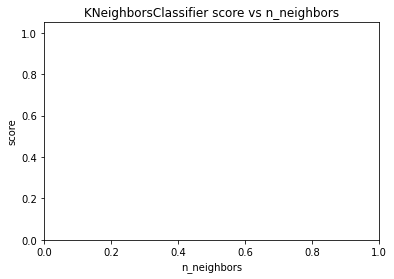

In [39]:

X_trn, X_tst = scale_data(X_trn, X_tst)
# train_neural_network(X, y)
train_kNN_estimators(X_trn, X_tst, y_trn, y_tst)
# train_random_forests(X_trn, X_tst, y_trn, y_tst)
clf = train_dummy_classifier(X_trn, y_trn)
y_pred = clf.predict(X_tst)
stats = sklearn.metrics.precision_recall_fscore_support(y_tst, y_pred, average='binary')
sklearn.metrics.accuracy_score(y_tst, y_pred)